In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt

from input_adapter import EEGDataAdapter
import pdb

# Load Data

In [2]:
loader = EEGDataAdapter('', 
    channel_indices=[1, 2, 3, 4, 5, 6, 7, 8], 
    mode='offline',
    event_dict={
        'noblink': 0, 
        'break': 1, 
        'imagery_handL': 2, 
        'imagery_handR': 3,
    }
)

DATA_FILE_NAME = '../../data/BF_MI_03'

# Load data
eeg_data, eeg_labels = loader.load_recorded_eeg_data_file(
    DATA_FILE_NAME, file_type='xdf'
)
eeg_data = eeg_data * 1e6  # scale for unicorn
reref_eeg_data = eeg_data - np.mean(eeg_data, axis=0)

{'noblink': 0, 'break': 1, 'imagery_handL': 2, 'imagery_handR': 3}
[INFO]: Opening an xdf file
Creating RawArray with float64 data, n_channels=17, n_times=59225
    Range : 0 ... 59224 =      0.000 ...   236.896 secs
Ready.
{'noblink': 0, 'break': 1, 'imagery_handL': 2, 'imagery_handR': 3}
[INFO]: selected events:['break', 'imagery_handL', 'imagery_handR']
Used Annotations descriptions: ['break', 'imagery_handL', 'imagery_handR']
Not setting metadata
Not setting metadata
41 matching events found
No baseline correction applied
Loading data for 41 events and 501 original time points ...
0 bad epochs dropped
[INFO]: Acquired  Data and labels


In [3]:
def visualise(
        data, 
        labels, 
        plot_name, 
        start_time=1, 
        duration=9, 
        channels=[1,3], 
        channel_names=['left', 'right'], 
        fs=250):
    '''Plot data'''
    assert len(channels) == len(channel_names)

    start_idx = fs*start_time
    end_idx = start_idx + fs*duration

    t = np.arange(start_time, start_time+duration, step=1/fs)

    fig, axs = plt.subplots(len(channels)+1, figsize=(12,12), sharex=True)
    fig.suptitle(plot_name)
    for i, channel in enumerate(channels):
        axs[i].plot(t, data[channel, start_idx:end_idx])
        axs[i].set_ylabel(f'{channel_names[i]} uV')
    axs[-1].plot(t, labels[start_idx:end_idx])

    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

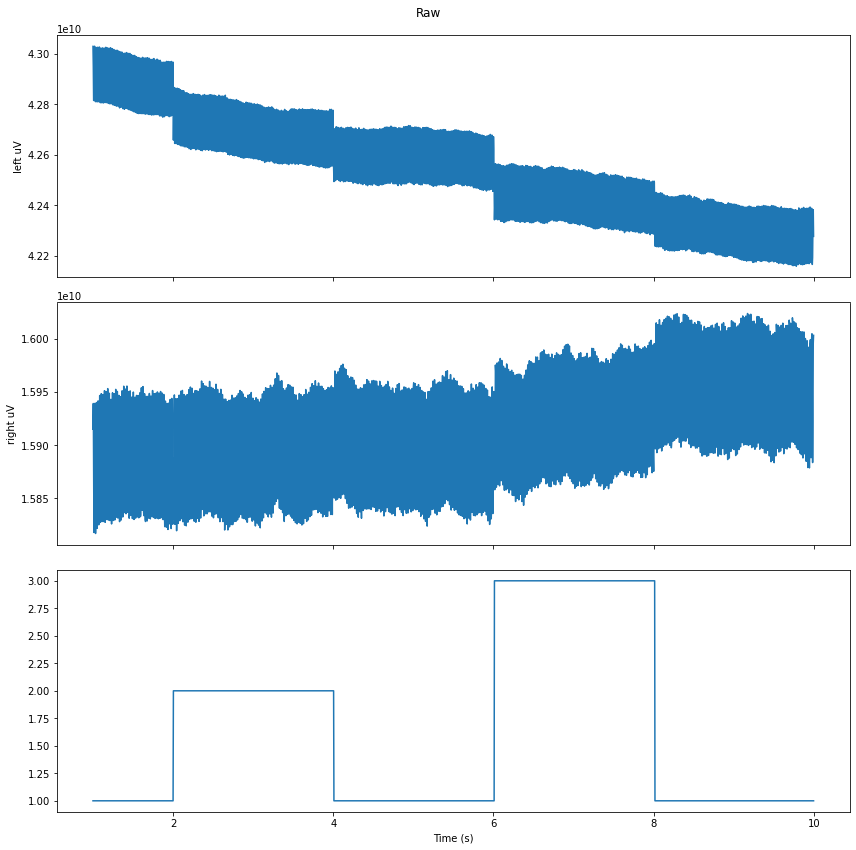

In [4]:
# Plot raw data
visualise(reref_eeg_data, eeg_labels, 'Raw')


# Use MNE

In [5]:
# Create MNE array from numpy data
print('To MNE...')
ch_names = ['EEG Fz', 'EEG C3', 'EEG Cz', 'EEG C4', 'EEG Pz', 'EEG PO7', 'EEG Oz', 'EEG PO8']
ch_types = ["eeg", "eeg", "eeg", "eeg", "eeg", "eeg", "eeg", "eeg"]
info = mne.create_info(
    ch_names=ch_names,
    sfreq=250, 
    ch_types=ch_types
)
raw = mne.io.RawArray(reref_eeg_data.copy(), info)

print(raw.info)

To MNE...
Creating RawArray with float64 data, n_channels=8, n_times=20541
    Range : 0 ... 20540 =      0.000 ...    82.160 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fz, EEG C3, EEG Cz, EEG C4, EEG Pz, EEG PO7, EEG Oz, EEG PO8
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>


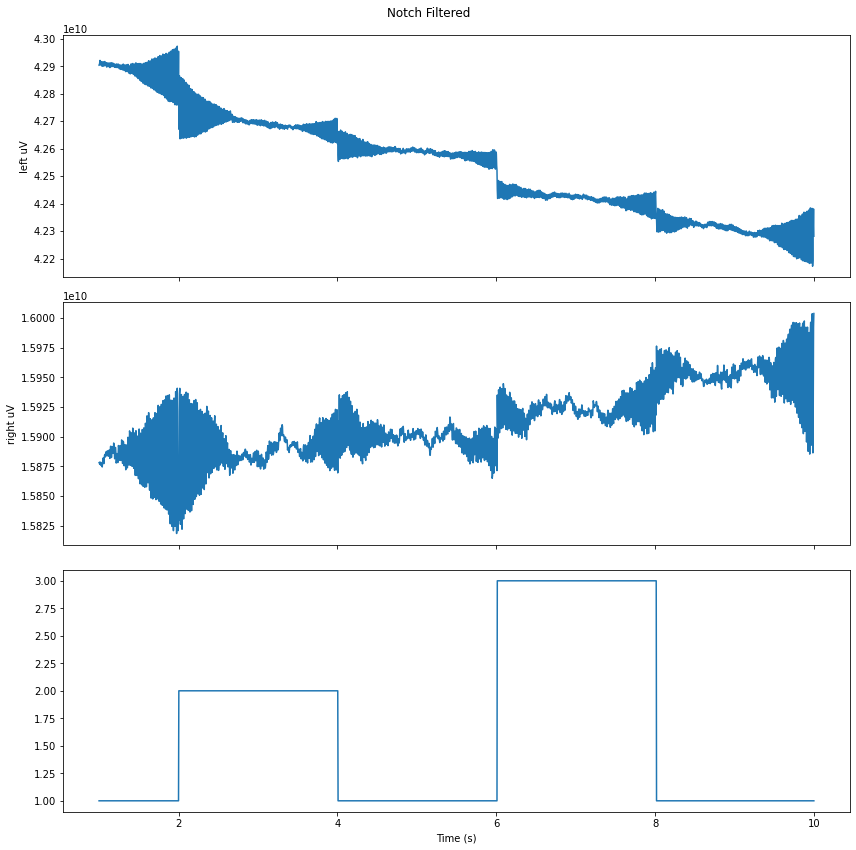

In [6]:
raw.notch_filter(50, filter_length='auto', fir_design='firwin', verbose=False)

visualise(raw._data, eeg_labels, 'Notch Filtered')

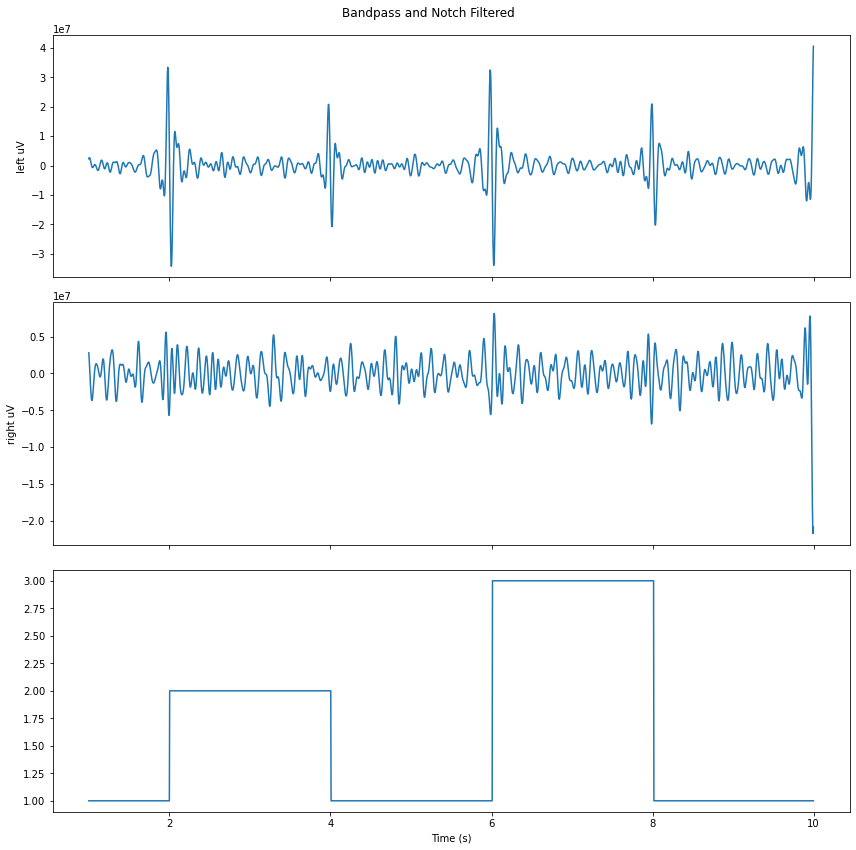

In [7]:
# Filter using MNE
raw.filter(7, 15, fir_design='firwin', verbose=False)

# Plot data
visualise(raw._data, eeg_labels, 'Bandpass and Notch Filtered')

# Events


In [17]:
# mne.find_events(raw, stim_channel='STI 014')

eeg_labels.reshape(1,-1).shape

(1, 20541)

In [18]:
ch_names = ['stim']
info = mne.create_info(
    ch_names=ch_names,
    sfreq=250
)
raw_labels = mne.io.RawArray(eeg_labels.reshape(1,-1).copy(), info)

Creating RawArray with float64 data, n_channels=1, n_times=20541
    Range : 0 ... 20540 =      0.000 ...    82.160 secs
Ready.


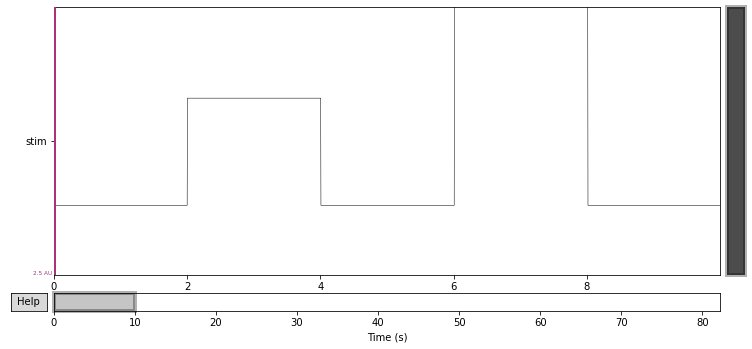

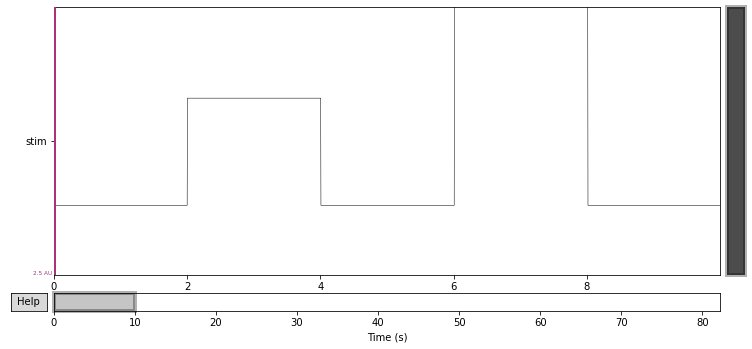

In [19]:
raw_labels.plot()

In [125]:
events = mne.find_events(raw_labels, stim_channel='stim')
event_id = dict(left=2, right=3)
tmin, tmax = 0.1, 1.9
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)

print(epochs._data.shape)

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
20 events found
Event IDs: [2 3]
Not setting metadata
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Loading data for 20 events and 451 original time points ...
0 bad epochs dropped
(20, 8, 451)


In [81]:
epochs

Number of events,20
Events,left: 10right: 10
Time range,0.100 – 1.900 sec
Baseline,off


    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for eeg. Disabling interactivity.


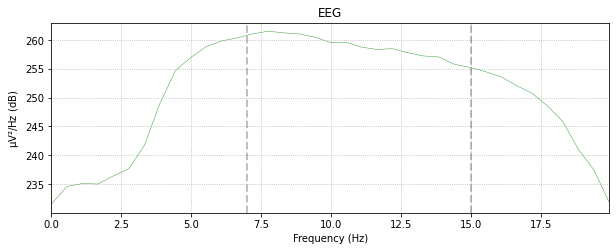

In [104]:
epochs['left'].plot_psd(fmax=20, picks=[3], spatial_colors=False, average=False, color='green')
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for eeg. Disabling interactivity.
<ipython-input-74-e718023d9928>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs['right'].plot_psd(fmax=20, color=('black', 'r'), picks=1)


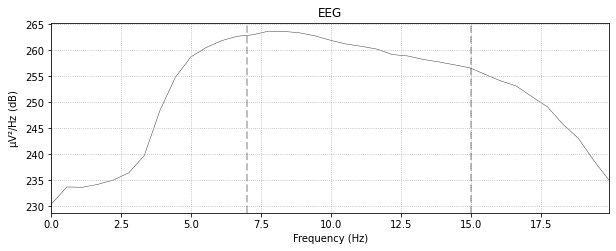

    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for eeg. Disabling interactivity.
<ipython-input-74-e718023d9928>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs['right'].plot_psd(fmax=20, color=('black', 'r'), picks=0)


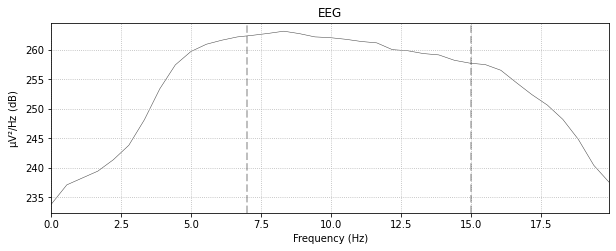

In [74]:
epochs['right'].plot_psd(fmax=20, color=('black', 'r'), picks=1)
epochs['right'].plot_psd(fmax=20, color=('black', 'r'), picks=0)
plt.show()

Effective window size : 1.024 (s)


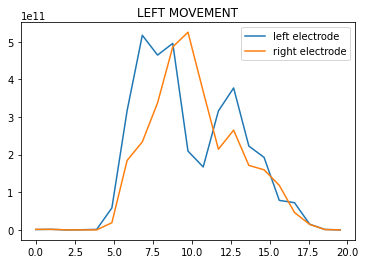

In [124]:
psds, freqs = mne.time_frequency.psd_welch(epochs['left'], fmax=20, picks=[1,3])
psds.shape

mean_psds = np.mean(psds, axis=0)
plt.title('LEFT MOVEMENT')
plt.plot(freqs, mean_psds[0], label='left electrode')
plt.plot(freqs, mean_psds[1], label='right electrode')
plt.legend()
plt.show()

Effective window size : 1.024 (s)


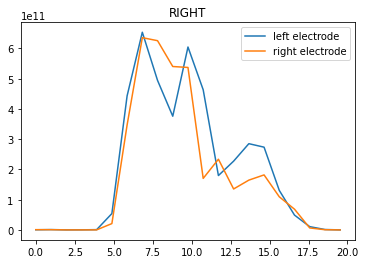

In [123]:
psds, freqs = mne.time_frequency.psd_welch(epochs['right'], fmax=20, picks=[1,3])
psds.shape

mean_psds = np.mean(psds, axis=0)
plt.title('RIGHT')
plt.plot(freqs, mean_psds[0], label='left electrode')
plt.plot(freqs, mean_psds[1], label='right electrode')
plt.legend()
plt.show()

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score


In [139]:
from mne.decoding import CSP

epochs_train = epochs.copy().crop(tmin=1, tmax=2)
labels = epochs.events[:, -1] - 2


# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

Computing rank from data with rank=None
    Using tolerance 2.8e+05 (2.2e-16 eps * 8 dim * 1.6e+20  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e+05 (2.2e-16 eps * 8 dim * 1.8e+20  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6e+05 (2.2e-16 eps * 8 dim * 1.5e+20  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.1e+05 (2.2e-16 eps * 8 dim * 1.7e+20  max singular value)
    Estimated rank 

In [82]:
montage_dir = os.path.join(os.path.dirname(mne.__file__),
                           'channels', 'data', 'montages')
print('\nBUILT-IN MONTAGE FILES')
print('======================')
print(sorted(os.listdir(montage_dir)))



BUILT-IN MONTAGE FILES
['EGI_256.csd', 'GSN-HydroCel-128.sfp', 'GSN-HydroCel-129.sfp', 'GSN-HydroCel-256.sfp', 'GSN-HydroCel-257.sfp', 'GSN-HydroCel-32.sfp', 'GSN-HydroCel-64_1.0.sfp', 'GSN-HydroCel-65_1.0.sfp', 'artinis-brite23.elc', 'artinis-octamon.elc', 'biosemi128.txt', 'biosemi16.txt', 'biosemi160.txt', 'biosemi256.txt', 'biosemi32.txt', 'biosemi64.txt', 'easycap-M1.txt', 'easycap-M10.txt', 'mgh60.elc', 'mgh70.elc', 'standard_1005.elc', 'standard_1020.elc', 'standard_alphabetic.elc', 'standard_postfixed.elc', 'standard_prefixed.elc', 'standard_primed.elc']


In [83]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
print(ten_twenty_montage)


<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 94 channels>


4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


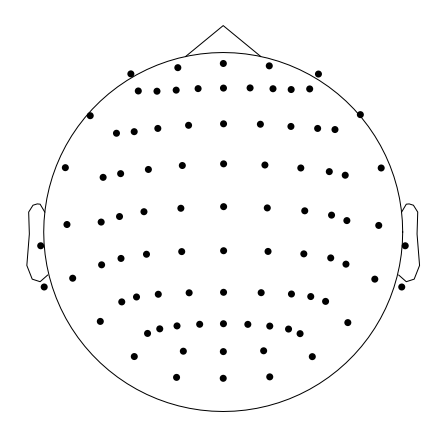

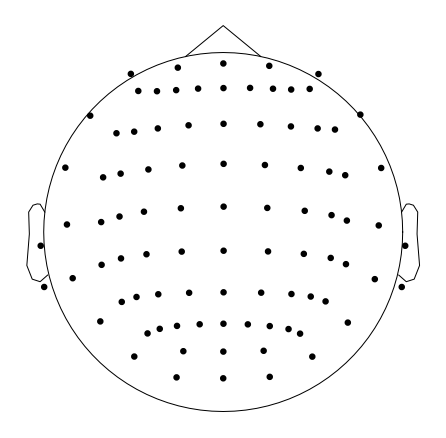

In [84]:
ten_twenty_montage.plot(kind='topomap', show_names=False)